In [1]:
#pySnowRadar modules
from pySnowRadar import SnowRadar, pick_layers
from pySnowRadar.processing import extract_layers, geo_filter, calc_snr
from pySnowRadar.qc import error_check
#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [53]:
radar_file = "../pySnowRadar/data/sr/20170309_01/Data_20170309_01_025.mat"
radar_dat = SnowRadar(radar_file, l_case='full')

Loading: Data_20170309_01_025.mat (full)


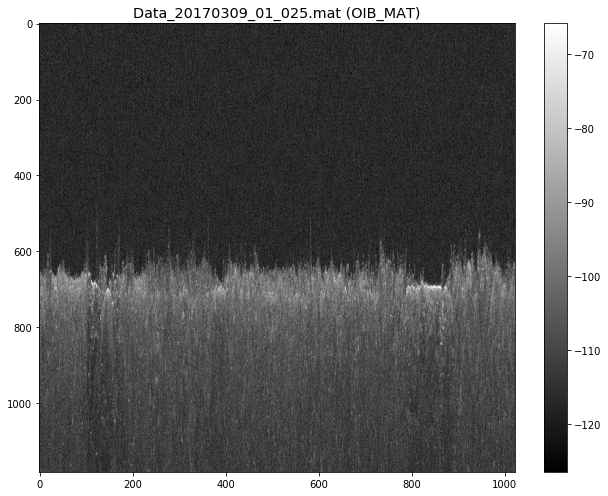

In [54]:
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()
radar_bounds = radar_dat.get_bounds(3,4)
#radar_sub = radar_dat.data_radar[radar_bounds[1]: radar_bounds[0], :]
radar_dat.plot_quicklook()

In [55]:
radar_dat.calcpulsewidth()
print(radar_dat.epw)
print(radar_dat.n2n)

0.028389437310606058
0.075697595645


In [56]:
res = extract_layers(radar_file, snow_density=0.3, picker='Wavelet-TN', dump_results=False)


Loading: Data_20170309_01_025.mat (full)


In [57]:
res['as_snr'] = calc_snr(radar_dat, noise_bins = 100, 
                        interfaces = res['b_as'].values+ res['b_ref'].values)
res['si_snr'] = calc_snr(radar_dat, noise_bins = 100, 
                        interfaces = res['b_si'].values+ res['b_ref'].values)

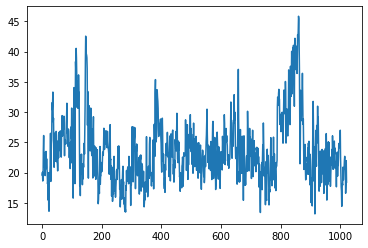

In [58]:
plt.plot(res['si_snr'])

In [59]:
# Smooth the si interface
res['b_si_smooth'] = res['b_si'].rolling(5).mean()
res['error_codes'] = pd.Series(error_check(radar_dat).tolist())
res.head()

,src,lat,lon,n_snow,b_ref,b_as,b_si,snow_depth,as_snr,si_snr,b_si_smooth,error_codes
0,Data_20170309_01_025.mat,83.753690,-84.574717,1.238066,266,383,453,0.830878,9.711250,19.609257,NaN,"[False, False, False, False, False, False]"
1,Data_20170309_01_025.mat,83.753723,-84.574977,1.238066,266,386,454,0.807138,8.775259,20.060520,NaN,"[False, False, False, False, False, False]"
2,Data_20170309_01_025.mat,83.753757,-84.575236,1.238066,266,386,437,0.605354,8.941792,18.619707,NaN,"[False, False, False, False, False, False]"
3,Data_20170309_01_025.mat,83.753790,-84.575496,1.238066,266,388,465,0.913965,8.492573,18.803740,NaN,"[False, False, False, False, False, False]"
4,Data_20170309_01_025.mat,83.753824,-84.575755,1.238066,266,389,444,0.652832,5.921214,23.826284,450.6,"[False, False, False, False, False, False]"


In [60]:
# Apply QA filters
res = res[(res['as_snr']>5) & # AS pick SNR must be > 5 dB
          (~res.error_codes.apply(any)) &  # Pitch and roll requirements
          (res.snow_depth > radar_dat.dfr)] # SD must be > than range res
print(res.shape)

(627, 12)


In [61]:
res['dist'] = haversine(res.lat, res.lon)
res['dist_along'] = res['dist'].cumsum()
dist_tol = 0.040  # Same as the nasa product

In [62]:
bins = pd.cut(res['dist_along'], np.arange(res['dist_along'].min(),res['dist_along'].max(),dist_tol))
snow_depth_agg = res.groupby(bins)['snow_depth'].agg(['count', 'median'])

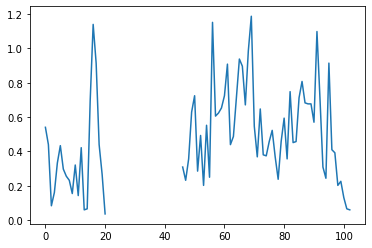

In [63]:
plt.plot(snow_depth_agg['median'].values)

C:\Users\KingJ\AppData\Local\Continuum\miniconda3\envs\py3-pySnowRadar\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\KingJ\AppData\Local\Continuum\miniconda3\envs\py3-pySnowRadar\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5., 1., 4., 2., 7., 5., 4., 5., 6., 6., 2., 3., 4., 5., 7., 1., 1.,
        0., 2., 3., 1., 0., 0., 2., 2.]),
 array([0.03560904, 0.0816634 , 0.12771776, 0.17377211, 0.21982647,
        0.26588083, 0.31193519, 0.35798954, 0.4040439 , 0.45009826,
        0.49615262, 0.54220698, 0.58826133, 0.63431569, 0.68037005,
        0.72642441, 0.77247876, 0.81853312, 0.86458748, 0.91064184,
        0.9566962 , 1.00275055, 1.04880491, 1.09485927, 1.14091363,
        1.18696798]),
 <a list of 25 Patch objects>)

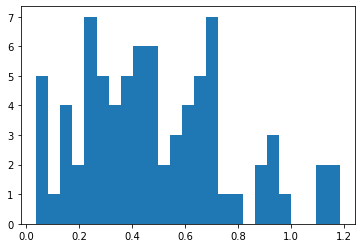

In [64]:
plt.hist(snow_depth_agg['median'].values, bins = 25)

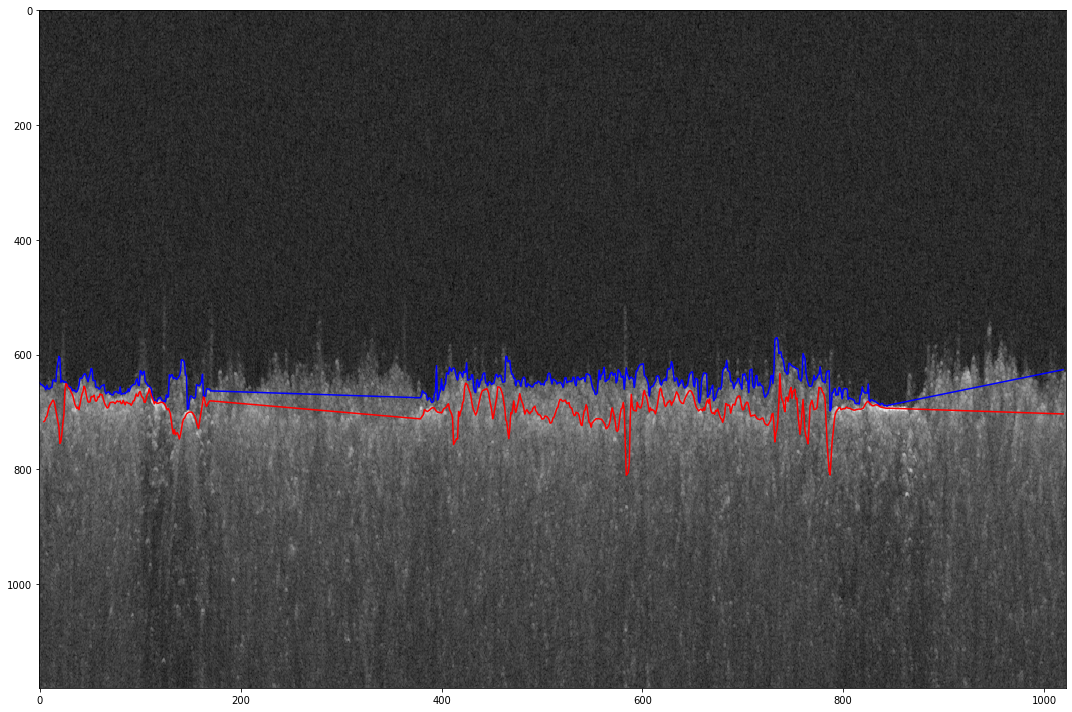

In [65]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_dat.data_radar), interpolation='nearest', cmap="gist_gray")
    
ax.plot(res['b_ref'] + res['b_as'], color='b')
ax.plot(res['b_ref']+ res['b_si_smooth'], color='r')
#ax.plot(radar_dat.surf_bin, color = 'k')
#ax.plot(res['b_ref'] + median_pick, color = 'yellow')

ax.set_aspect('auto')
fig.tight_layout();

In [103]:
########### SCRATCH AFTER HERE

theta_insnow = np.degrees(np.arcsin((1/res['n_snow'])*np.sin(np.radians(np.abs(res['roll'])))))

res['adjusted_sd'] = res['snow_depth'] * np.sin(np.radians(90 - theta_insnow))

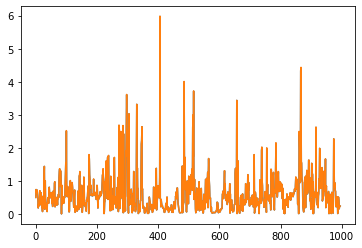

In [104]:
plt.plot(adjusted_sd)
plt.plot(res['snow_depth'])

snow_depth_adj = res.groupby(bins)['adjusted_sd'].agg(['count', 'median'])


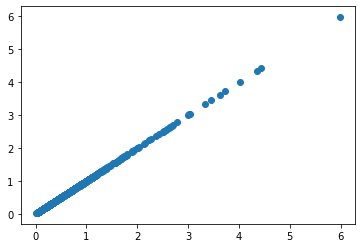

In [101]:
plt.scatter(res['snow_depth'],adjusted_sd)

(array([  2.,   0.,   1.,   1.,   4.,  18.,  33.,  94., 139., 704.]),
 array([-2.57082625e-02, -2.31374362e-02, -2.05666100e-02, -1.79957838e-02,
        -1.54249576e-02, -1.28541314e-02, -1.02833052e-02, -7.71247896e-03,
        -5.14165275e-03, -2.57082654e-03, -3.26687493e-10]),
 <a list of 10 Patch objects>)

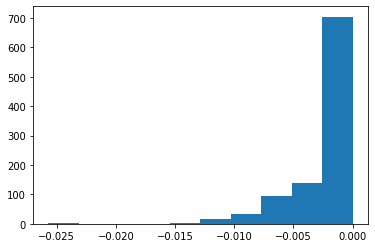

In [102]:
plt.hist((adjusted_sd - res['snow_depth']))

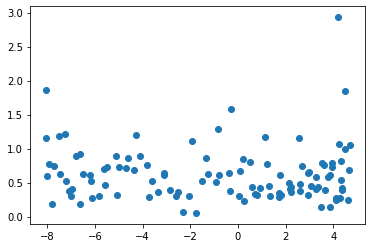

In [39]:
plt.scatter(roll_agg['median'].values, snow_depth_agg['median'].values)

In [33]:
for idx, row in res.iterrows():
    print(row['dist_along'])
    if row['dist_along'] < dist_tol:

nan
0.005152435639499926
0.010304459195142147
0.015456257344499284
0.020607736055767295
0.025758800612679857
0.030909445935415038
0.036059774890718495
0.04120978143305111
0.046359503400591834
0.05150876190020968
0.056657699531340276
0.06180625688280229
0.06695447056118099
0.07210245032897247
0.07724991427537169
0.08239720662171264
0.08754407465669664
0.0926906424796903
0.0978370191402336
0.10298284427975533
0.10812853160413667
0.11327388260487917
0.11841883576053204
0.1235636241581397
0.1287078927505715
0.13385199431413974
0.13899575296941347
0.14413916191986934
0.14928218009666352
0.15442510624285705
0.15956757680858677
0.16470971962453912
0.16985166750065547
0.1749930676097878
0.1801343613260256
0.18527528652136654
0.19041595790584043
0.19555626393758124
0.20069622129674589
0.20583598430973124
0.21097544060549478
0.21611454588443493
0.22125328813924278
0.22639172738459
0.23152995859005002
0.23666793962898658
0.24180551068265776
0.2469427409800559
0.25207970554645875
0.257216502608621

In [ ]:
for row in range(res.shape[0] - 1):

    # From comments:
    # if less than limit distance { store Val of current row for aggregation}
    # else { perform aggregation on stored Vals and change reference to current row } repeat

    if consec_dist[row] < d:
        df.loc[row, 'mean'] = df.loc[row, 'Val']
    else:
        df.loc[row, 'mean'] = df.loc[row:row + 1, 'Val'].mean()

In [67]:
lat1, lon1, lat2, lon2 = np.radians([2, 2, 2, 2])
a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

In [44]:
res_filter = res[~res['error_codes'].apply(any)]

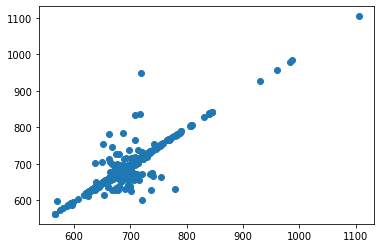

In [56]:
plt.scatter(radar_dat.surf_bin, res['b_ref']+ res['b_si'])

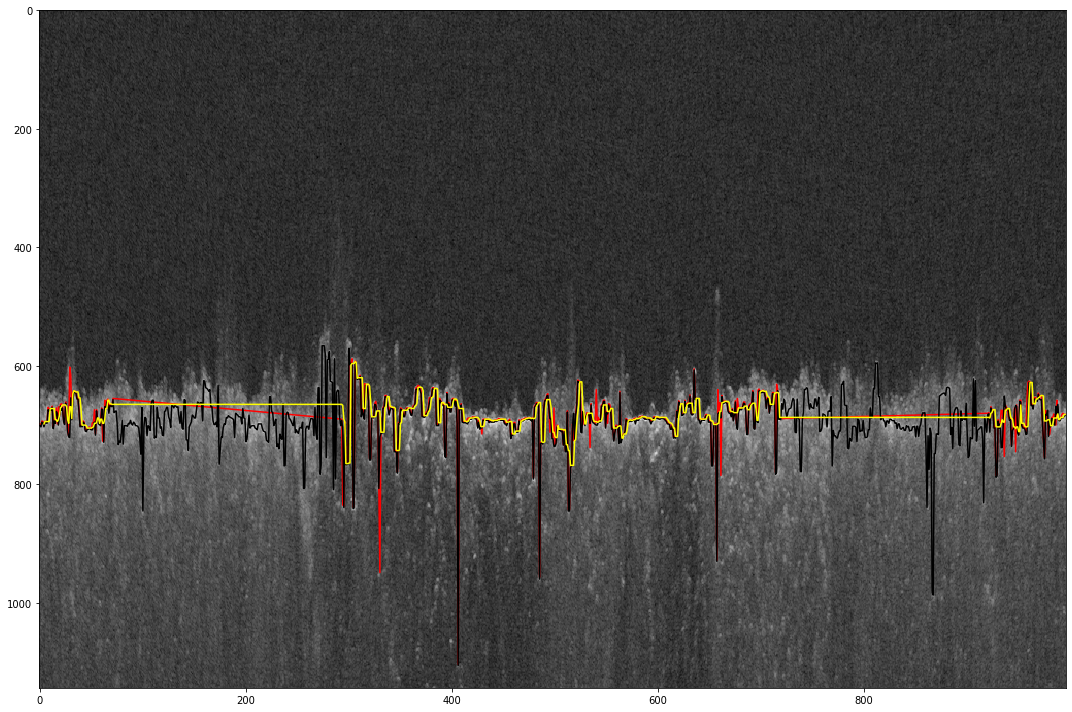

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_dat.data_radar), interpolation='nearest', cmap="gist_gray")
    
#ax.plot(res_filter['b_ref'] + res_filter['b_as'], color='b')
ax.plot(res_filter['b_ref']+ res_filter['b_si'], color='r')
ax.plot(radar_dat.surf_bin, color = 'k')
ax.plot(res_filter['b_ref'] + median_pick, color = 'yellow')

ax.set_aspect('auto')
fig.tight_layout();

In [60]:
median_pick  = res_filter['b_si'].rolling(5).median()

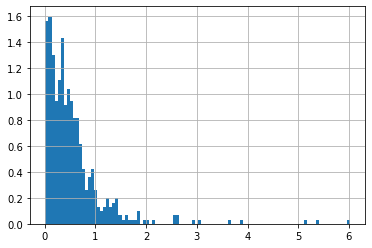

In [23]:
res.snow_depth.hist(bins = 100, density = True)

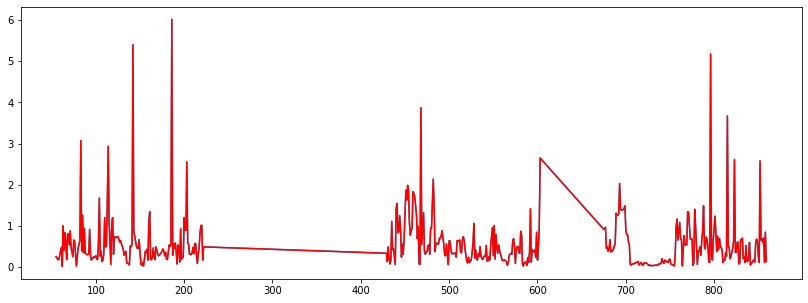

In [24]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(res.snow_depth)
ax.plot(res.snow_depth[~res['error_codes'].apply(any)], color = 'r')

In [49]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow


N = 10
snow_depth_rollin = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)

snow_depth[~valid_data] = np.nan

print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

NameError: name 'l_si' is not defined

In [25]:
plt.hist(snow_depth, bins = 20)

NameError: name 'snow_depth' is not defined

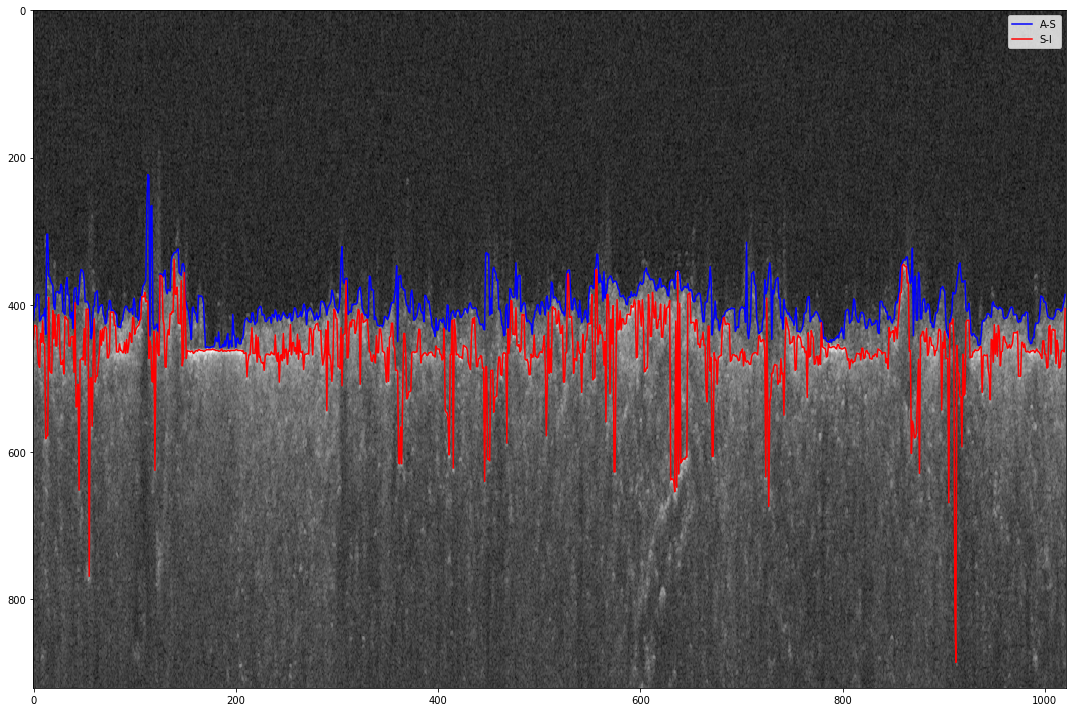

In [403]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_aspect('auto')
fig.tight_layout();

693


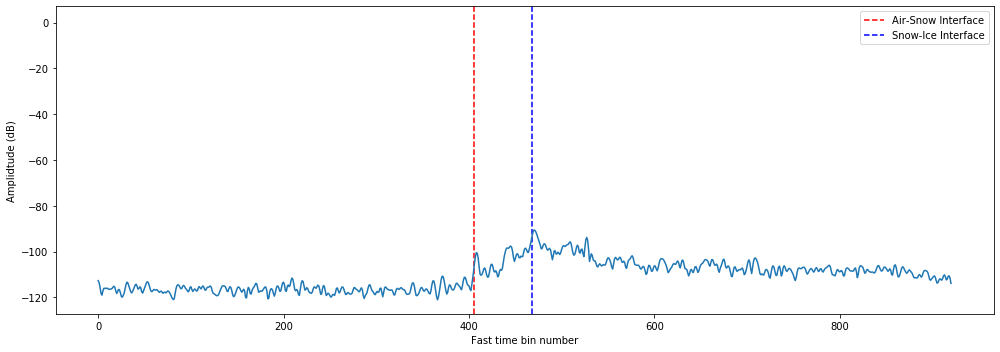

In [404]:
col_idx = np.random.randint(0, radar_sub.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
with np.errstate(divide='ignore'):
    ax.plot(10*np.log10(radar_sub[:,col_idx]), label=None)
# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
fig.tight_layout();

In [223]:
l_as[~valid_data] = np.nan

ValueError: cannot convert float NaN to integer

In [205]:
fig, ax = plt.subplots(figsize=(15,10))
with np.errstate(divide='ignore'):
    ax.imshow(20 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray")
ax.plot(l_as, color='b')
ax.plot(l_si, color='r')
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_aspect('auto')
fig.tight_layout();

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False,